In [1]:
from itertools import count
import json
from warnings import simplefilter
import random
import pickle

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from termcolor import colored, cprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
from scipy import stats

import pymc3 as pm
import arviz as az
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as proportion

for w in (DeprecationWarning, FutureWarning, RuntimeWarning):
    simplefilter(action='ignore', category=w)

plt.rcParams['figure.figsize'] = (15, 8)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Simulation
Generate trajectories_h0: at each time step, gather new data, and compute the p-value and a bayesian decision criterion.

The setup is an A/B test with binary outcome.

In [2]:
def bayesian_analysis(successes_a, n_samples_a, successes_b, n_samples_b,
                      alpha_prior=1, beta_prior=1, alpha=.05, rope=(-.1, .1), resolution=10000):
    a_rvs = sp.stats.beta.rvs(alpha_prior + successes_a, beta_prior + n_samples_a - successes_a, size=resolution)
    b_rvs = sp.stats.beta.rvs(alpha_prior + successes_b, beta_prior + n_samples_b - successes_b, size=resolution)
    delta = b_rvs - a_rvs
    
    bins = np.linspace(np.min(delta) - 0.2 * abs(np.min(delta)),
                       np.max(delta) + 0.2 * abs(np.max(delta)), resolution)
    pdf, _ = np.histogram(delta, bins=bins, density=True)    
    x = 0.5 * (bins[0:-1] + bins[1:])
    k = np.linspace(0, max(pdf), 1000)
    area_above = np.array([np.trapz(pdf[pdf >= kk], x[pdf >= kk]) for kk in k])
    index = np.argwhere(np.abs(area_above - (1 - alpha)) == np.min(np.abs(area_above - (1 - alpha))))[0]
    hpd = x[pdf >= k[index]]
    
    return {
        'proba_h0': ((delta >= rope[0]) & (delta <= rope[1])).mean(),
        'proba_ha': (delta < rope[0]).mean(),
        'proba_hb': (delta > rope[1]).mean(),
        'hpd_lower': hpd[0],
        'hpd_upper': hpd[-1],
    }

In [863]:
def frequentist_analysis(successes_a, n_samples_a, successes_b, n_samples_b, alpha=0.05):
    _, pvalue = stats.fisher_exact([
        [n_samples_a - successes_a, successes_a],
        [n_samples_b - successes_b, successes_b],
    ])
    ci_lower, ci_upper = proportion.confint_proportions_2indep(successes_a, n_samples_a, successes_b, n_samples_b,
                                                               alpha=alpha, method='newcomb')
    return {
        'pvalue': pvalue,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
    }

In [4]:
def generate_trajectory(prob_a, prob_b, length, step_size, seed=0):
    np.random.seed(seed)
    samples_a = np.array([])
    samples_b = np.array([])
    experiments = []
    for i in tqdm(range(length)):
        samples_a = np.concatenate([samples_a, np.random.binomial(1, prob_a, size=step_size)])
        samples_b = np.concatenate([samples_b, np.random.binomial(1, prob_b, size=step_size)])
        args = {
            'successes_a': samples_a.sum(),
            'successes_b': samples_b.sum(),
            'n_samples_a': len(samples_a),
            'n_samples_b': len(samples_b),
        }
        experiments.append({
            **args, **bayesian_analysis(**args), **frequentist_analysis(**args),
        })
    df = pd.DataFrame(experiments)
    prior = bayesian_analysis(0, 0, 0, 0)
    df['bayes_factor'] = (1 - df.proba_h0) / df.proba_h0 * prior['proba_h0'] / (1 - prior['proba_h0'])
    return df

In [5]:
def plot_trajectory(trajectory):
    plt.subplot(1,2,1)
    trajectory.hpd_upper.plot(label='hpd_upper', color='dodgerblue')
    plt.plot([.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    trajectory.hpd_lower.plot(label='hpd_lower', color='blue')
    plt.plot([-.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    _ = plt.legend()

    plt.subplot(1,2,2)
    trajectory.pvalue.plot(label='pvalue', color='red')
    plt.plot([.05] * len(trajectory), label='pvalue threshold', color='red', linestyle='dashed')
    _ = plt.legend()

In [6]:
try:
    with open('trajectories_h0.pkl', 'rb') as f:
        trajectories_h0 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.3, length=100, step_size=20, seed=seed)

    trajectories_h0 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h0.pkl', 'wb+') as f:
        pickle.dump(trajectories_h0, f)

In [7]:
try:
    with open('trajectories_h1.pkl', 'rb') as f:
        trajectories_h1 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.35, length=100, step_size=20, seed=seed)

    trajectories_h1 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h1.pkl', 'wb+') as f:
        pickle.dump(trajectories_h1, f)

# p-value is meaningless if monitored continuously

In [8]:
def plot_pvalue_trajectories(trajectories, proba_a, proba_b):
    labels = {
        'green': f'Eventually significant ({sum((traj.pvalue.iloc[-1] <= .05).sum() for traj in trajectories)})',
        'coral': f'Significant at least once ({sum(((traj.pvalue <= .05).any()).sum() for traj in trajectories)})',
        'gray': f'Non-significant ({sum(((traj.pvalue > .05).all()).sum() for traj in trajectories)})',
    }
    plt.yscale('log')
    plt.title(f'p-value evolution across time, '
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Sample size (same for A and B)')
    plt.ylabel('p-value (log scale)')
    plt.plot(trajectories[0].n_samples_a, [.05] * len(trajectories[0]),
             linestyle='dashed', color='red', label='0.05 threshold')
    for traj in trajectories:
        if traj.pvalue.iloc[-1] <= .05:
            color = 'green'
        elif (traj.pvalue <= .05).any():
            color = 'coral'
        else:
            color = 'gray'
        label = labels.get(color)
        alpha = random.random()
        if label:
            alpha = 1
            del labels[color]
        plt.plot(traj.n_samples_a, traj.pvalue, color=color, linewidth=1, label=label, alpha=alpha)
    _ = plt.legend()

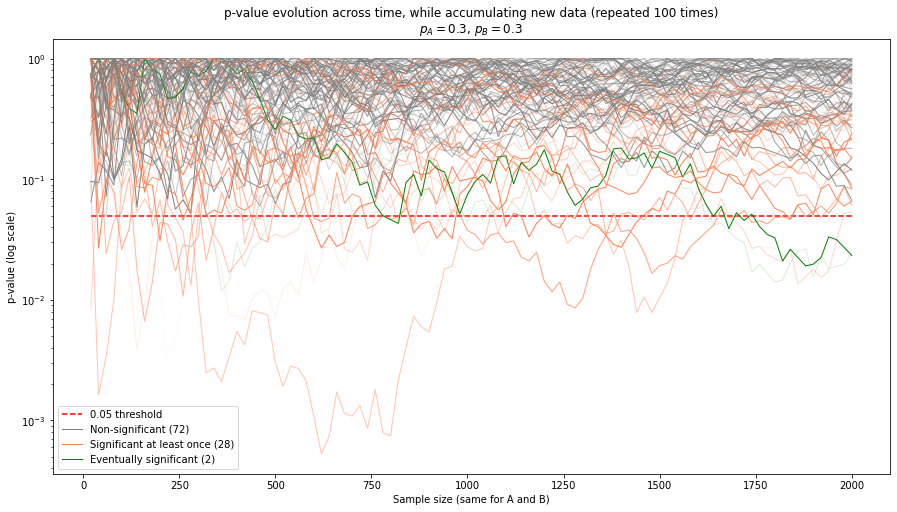

In [9]:
plot_pvalue_trajectories(trajectories_h0, .3, .3)

## Confidence intervals are useless either

In [10]:
def plot_lower_ci_trajectories(trajectories, proba_a, proba_b):
    labels = {
        'green': f'Confidence interval eventually overlaps 0 '
                 f'({sum((traj.ci_lower.iloc[-1] >= 0).sum() for traj in trajectories)})',
        'coral': f'Confidence interval overlapped 0 at least once '
                 f'({sum(((traj.ci_lower >= 0).any()).sum() for traj in trajectories)})',
        'gray': f'Confidence interval never overlaps 0 '
                f'({sum(((traj.ci_lower < 0).all()).sum() for traj in trajectories)})',
    }
    plt.title(f'Evolution across time of the lower bound confidence interval for the mean difference, \n'
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Sample size (same for A and B)')
    plt.ylabel('Confidence interval lower bound')
    plt.ylim(ymin=-.1, ymax=max(traj.ci_lower.max() for traj in trajectories))
    plt.plot(trajectories[0].n_samples_a, [0] * len(trajectories[0]),
             color='red', linestyle='dashed', label='0 threshold')
    for traj in trajectories:
        if traj.ci_lower.iloc[-1] > 0:
            color = 'green'
        elif (traj.ci_lower > 0).any():
            color = 'coral'
        else:
            color = 'gray'
        label = labels.get(color)
        alpha = random.random()
        if label:
            alpha = 1
            del labels[color]
        plt.plot(traj.n_samples_a, traj.ci_lower, color=color, linewidth=1, alpha=alpha, label=label)
        _ = plt.legend()

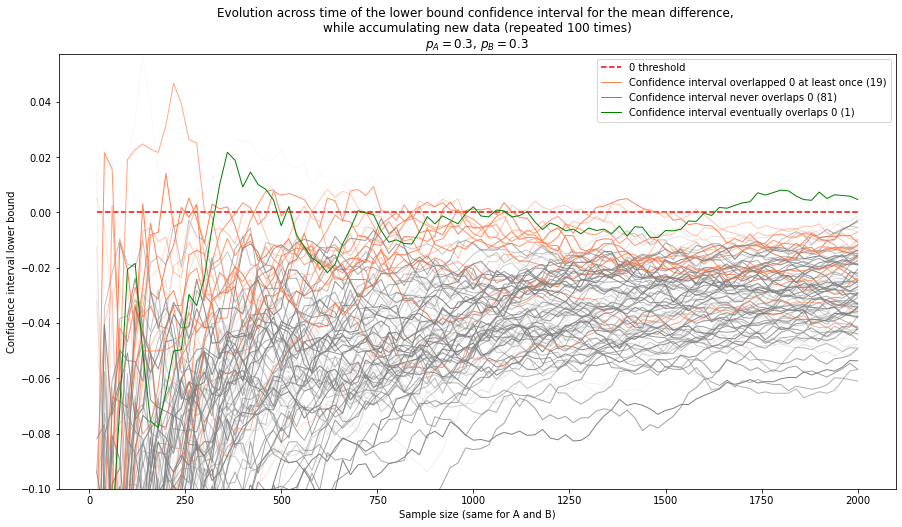

In [11]:
plot_lower_ci_trajectories(trajectories_h0, .3, .3)

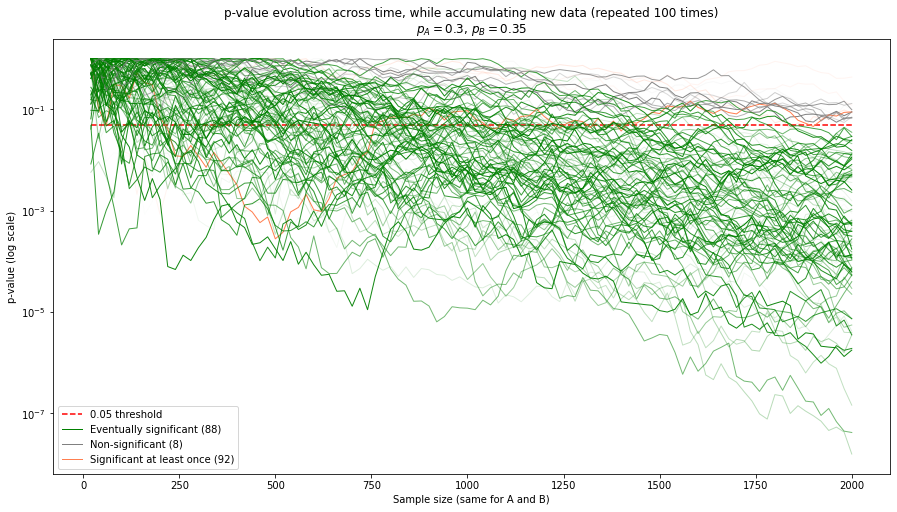

In [12]:
plot_pvalue_trajectories(trajectories_h1, .3, .35)

## Bayesian approach

In [13]:
# prior = bayesian_analysis(np.array([]), np.array([]))
# for traj in trajectories_h0:
#     traj['bayes_factor'] = ((1 - traj.proba_h0) / traj.proba_h0) * (prior['proba_h0'] / (1 - prior['proba_h0']))

In [962]:
def plot_bayesian_trajectories(trajectories, proba_a, proba_b):
    labels = {
        'coral': f'Some practical effect mistakenly detected at the beginning ({sum(((traj.bayes_factor >= 3).any()).sum() for traj in trajectories)})',
        'gray': f'No practical effect ({sum(((traj.bayes_factor < 3).all()).sum() for traj in trajectories)})',
    }
    plt.figure(figsize=(15, 8))
    n = len(trajectories[0])
    plt.yscale('log')
    plt.title(f'Bayes factor evolution across time, '
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Sample size (same for A and B)')
    plt.ylabel('Bayes factor against the null hypothesis (log scale)')
    plt.fill_between(range(n), [100] * n, [1000] * n, color='crimson', alpha=.30, label='Decisive')
    plt.fill_between(range(n), [10] * n, [100] * n, color='crimson', alpha=.20, label='Strong')
    plt.fill_between(range(n), [3.2] * n, [10] * n, color='crimson', alpha=.1, label='Substantial')
    plt.fill_between(range(n), [1] * n, [3.2] * n, color='crimson', alpha=.05, label='Not worth more than a bare mention')
    plt.fill_between(range(n), [0] * n, [1] * n, color='white', alpha=0, label='Negative')
    
    for traj in trajectories:
        if (traj.bayes_factor >= 3).any():
            color = 'coral'
        else:
            color = 'darkgray'
        label = labels.get(color)
        alpha = random.random()
        if label:
            alpha = 1
            del labels[color]
        plt.plot(traj.bayes_factor + 1e-4, color=color, linewidth=1, alpha=alpha, label=label)
    _ = plt.legend(loc='lower left')

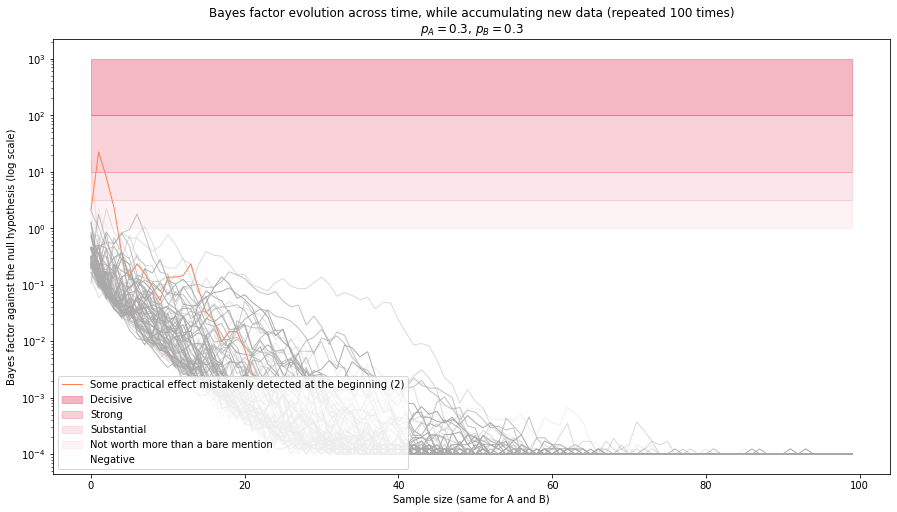

In [963]:
plot_bayesian_trajectories(trajectories_h0, .3, .3)

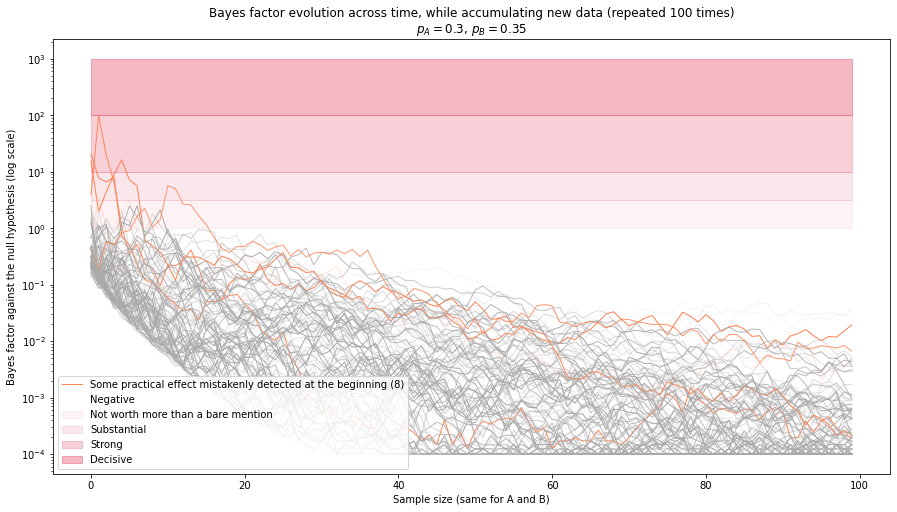

In [16]:
plot_bayesian_trajectories(trajectories_h1, .3, .35)

In [1044]:
def plot_rope_decisions(trajectories, proba_a, proba_b, rope=(-.1, .1)):
    plt.title(f'ROPE decision evolution across time,\n'
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Time (10 new data points at each time step)')
    plt.ylabel('Proportion of each decision')
    counts_h1 = np.sum([(traj.hpd_lower > rope[1]) | (traj.hpd_upper < rope[0]) for traj in trajectories], axis=0)
    counts_h0 = np.sum([(traj.hpd_lower >= rope[0]) & (traj.hpd_upper <= rope[1]) for traj in trajectories], axis=0)
    counts_undecided = len(trajectories) - counts_h1 - counts_h0 
    plt.plot(counts_h1, label='A is practically better than B, or the opposite.', color='darkgreen')
    plt.plot(counts_h0, label='A and B are practically equivalent', color='crimson')
    plt.plot(counts_undecided, label='Undecided', color='gray')
    _ = plt.legend()

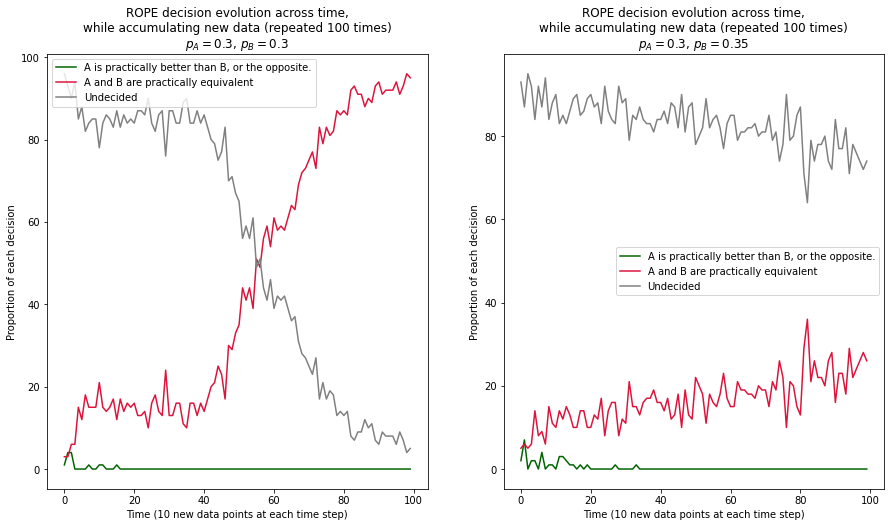

In [1045]:
plt.subplot(1,2,1)
plot_rope_decisions(trajectories_h0, .3, .3)
plt.subplot(1,2,2)
plot_rope_decisions(trajectories_h1, .3, .35)

# A practical example
Involving Markov chain Monte Carlos (MCMC) sampling, easy with PyMC3

## Discrete outcome

### Generate the data

In [945]:
np.random.seed(9)
samples_a = np.random.binomial(1, .3, size=5000)
samples_b = np.random.binomial(1, .31, size=5000)
samples_a.mean(), samples_b.mean()

(0.2924, 0.3182)

### Frequentist analysis

In [947]:
frequentist_analysis(samples_a.sum(), len(samples_a), samples_b.sum(), len(samples_b))

{'pvalue': 0.00544179854836149,
 'ci_lower': -0.043829587661363634,
 'ci_upper': -0.007747411221645763}

### Build the model

In [969]:
ROPE = (-.01, .01)
PRIOR_PROBA_H0 = .5

In [970]:
def prior_proba_h0_(psi_std, rope, psi_mean=0, beta_mean=0, beta_std=1, bounds=(-10, 1), resolution=10000):
    psi = sp.stats.norm.rvs(loc=psi_mean, scale=psi_std, size=resolution)
    beta = sp.stats.norm.rvs(loc=beta_mean, scale=beta_std, size=resolution)
    p_2 = 1 / (1 + np.exp(-beta - psi / 2))
    p_1 = 1 / (1 + np.exp(-beta + psi / 2))
    difference = p_2 - p_1
    bins = np.linspace(bounds[0], bounds[1], resolution)
    difference_pdf, _ = np.histogram(difference, bins=bins, density=True)
    x = 0.5 * (bins[0:-1] + bins[1:])
    in_rope = (x >= rope[0]) & (x <= rope[1])
    area_rope = np.trapz(difference_pdf[in_rope], x[in_rope])
    return area_rope

In [971]:
def elicit_prior(target_proba_h0, rope, **kwargs):
    def optim_objective(psi_std):
        return prior_proba_h0_(psi_std, rope=rope, **kwargs) - target_proba_h0
    result = sp.optimize.root_scalar(optim_objective, x0=1, method='ridder', bracket=[1e-3, 50])
    return result.root

In [972]:
psi_std = elicit_prior(target_proba_h0=PRIOR_PROBA_H0, psi_mean=0, beta_mean=0, beta_std=1.5, rope=ROPE)

In [973]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1.5)
    psi = pm.Normal("psi", mu=0, sigma=psi_std)
    
    logit_a = pm.Deterministic("logit_a", beta - psi/2)
    logit_b = pm.Deterministic("logit_b", beta + psi/2)
    
    observed_a = pm.Bernoulli("observed_a", logit_p=logit_a, observed=samples_a)
    observed_b = pm.Bernoulli("observed_b", logit_p=logit_b, observed=samples_b)
    
    proba_a = pm.Deterministic("proba_a", 1 / (1 + np.exp(-logit_a)))
    proba_b = pm.Deterministic("proba_b", 1 / (1 + np.exp(-logit_b)))
    
    difference = pm.Deterministic("difference", proba_b - proba_a)

In [974]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


### Check convergence

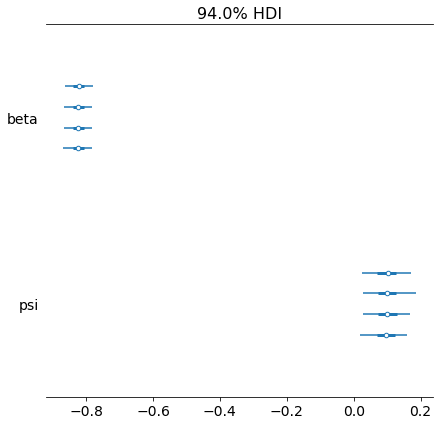

In [979]:
with model:
    pm.forestplot(trace, var_names=["beta", "psi"])

### Check prior and posterior predictive distributions

In [980]:
with model:
    prior_predictive = pm.sample_prior_predictive(var_names=["observed_a", "observed_b", "difference"], samples=1000)

In [981]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["observed_a", "observed_b", "difference"])

In [982]:
def plot_distributions(data, kind, rope):
    proba_h0 = ((data['difference'] >= rope[0]) & (data['difference'] <= rope[1])).mean()
    condition = '|\mathcal{D}' if kind == 'Posterior' else ''
    
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.title(f"{kind} predictive distribution of observed outcome")
    plt.hist(data['observed_a'].mean(axis=1), color='dodgerblue', alpha=.3, density=True, bins=20,
            label=f"$p(A{condition})$")
    plt.hist(data['observed_b'].mean(axis=1), color='coral', alpha=.3, density=True, bins=20,
            label=f"$p(B{condition})$")
    _ = plt.legend()

    plt.subplot(1,2,2)
    plt.title(f"{kind} predictive distribution of the difference between means")
    y, *_ = plt.hist(data['difference'], color='coral', alpha=.3, density=True, bins=20)
    plt.vlines(rope, ymin=0, ymax=y.max() * 1.1, color='darkgreen', linestyle='dashed', linewidth=1)
    plt.fill_betweenx([0, y.max() * 1.1], rope[0], rope[1], color='green', alpha=.1,
                      label=f"$p(H_0{condition}) = {proba_h0:0.3f}$")
    _ = plt.legend()
    return proba_h0

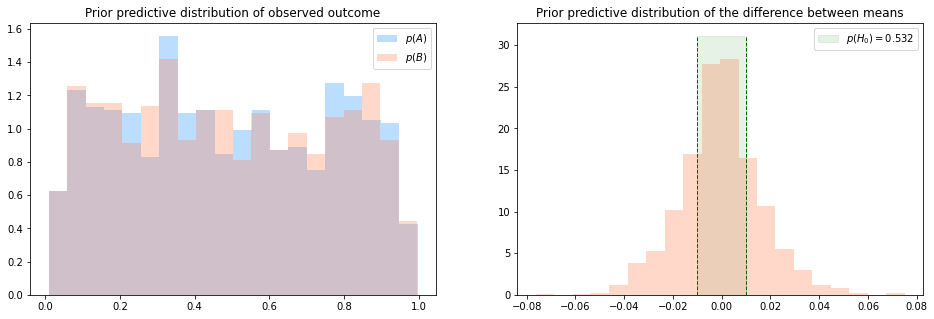

In [983]:
prior_proba_h0 = plot_distributions(prior_predictive, "Prior", rope=ROPE)

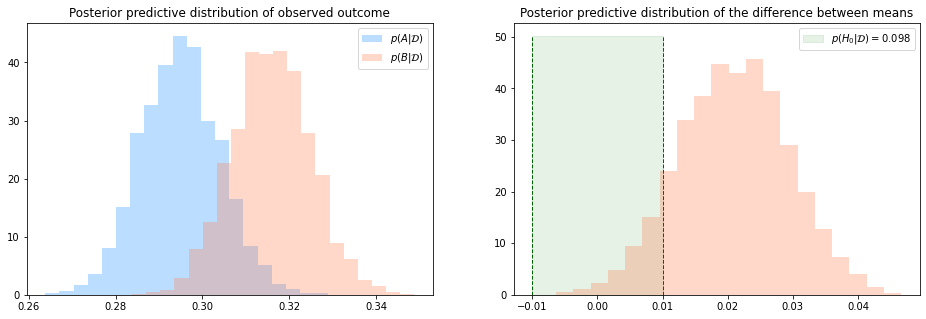

In [984]:
proba_h0 = plot_distributions(posterior_predictive, "Posterior", rope=ROPE)

### Final results

In [993]:
proba_h0

0.09775

In [994]:
bayes_factor = (1 - proba_h0) / proba_h0  * prior_proba_h0 / (1 - prior_proba_h0)
bayes_factor

10.492425732834942

## Continuous outcome

In [1002]:
np.random.seed(3)
samples_a = np.random.normal(loc=10, scale=5, size=1000)
samples_b = np.random.normal(loc=10, scale=5, size=1000)

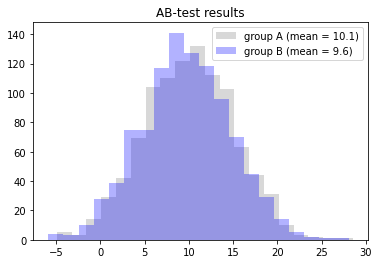

In [1003]:
plt.figure(figsize=(6, 4))
plt.title(f'AB-test results')
plt.hist(samples_a, color='gray', alpha=.3, label=f'group A (mean = {samples_a.mean():.1f})', bins=20)
plt.hist(samples_b, color='blue', alpha=.3, label=f'group B (mean = {samples_b.mean():.1f})', bins=20)
_ = plt.legend()

### Frequentist analysis

In [1015]:
cm = sms.CompareMeans(sms.DescrStatsW(samples_a), sms.DescrStatsW(samples_b))
cm.summary(alpha=.05, usevar='unequal')

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.4699,0.226,2.080,0.038,0.027,0.913


### Build the model

In [1005]:
samples_all = np.concatenate([samples_a, samples_b])

def build_model(samples, suffix='a'):
    mean = pm.Normal("mean" + suffix, mu=samples_all.mean(), sigma=samples_all.std() * 2)
    std = pm.Uniform("std" + suffix, lower=1, upper=20)
    observed = pm.Normal("observed" + suffix, mu=mean, sigma=std, observed=samples)
    return observed

with pm.Model() as model:
    observed_a = build_model(samples_a, "_a")
    observed_b = build_model(samples_b, "_b")
    difference = pm.Deterministic("difference", model.mean_b - model.mean_a)
    rel_increase = pm.Deterministic("relative increase", difference / model.mean_a)

## Sample parameters posterior

In [1006]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [std_b, mean_b, std_a, mean_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


### Checks convergence

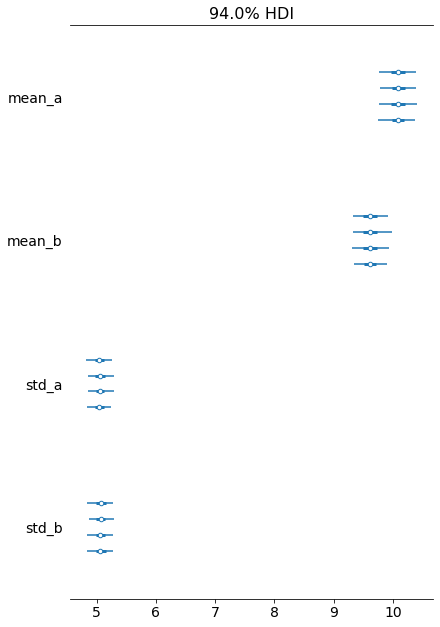

In [1007]:
with model:
    pm.forestplot(trace, var_names=["mean_a", "mean_b", "std_a", "std_b"])

### Prior predictive check

In [1028]:
with model:
    prior_predictive = pm.sample_prior_predictive(var_names=["observed_a", "observed_b", "relative increase"])

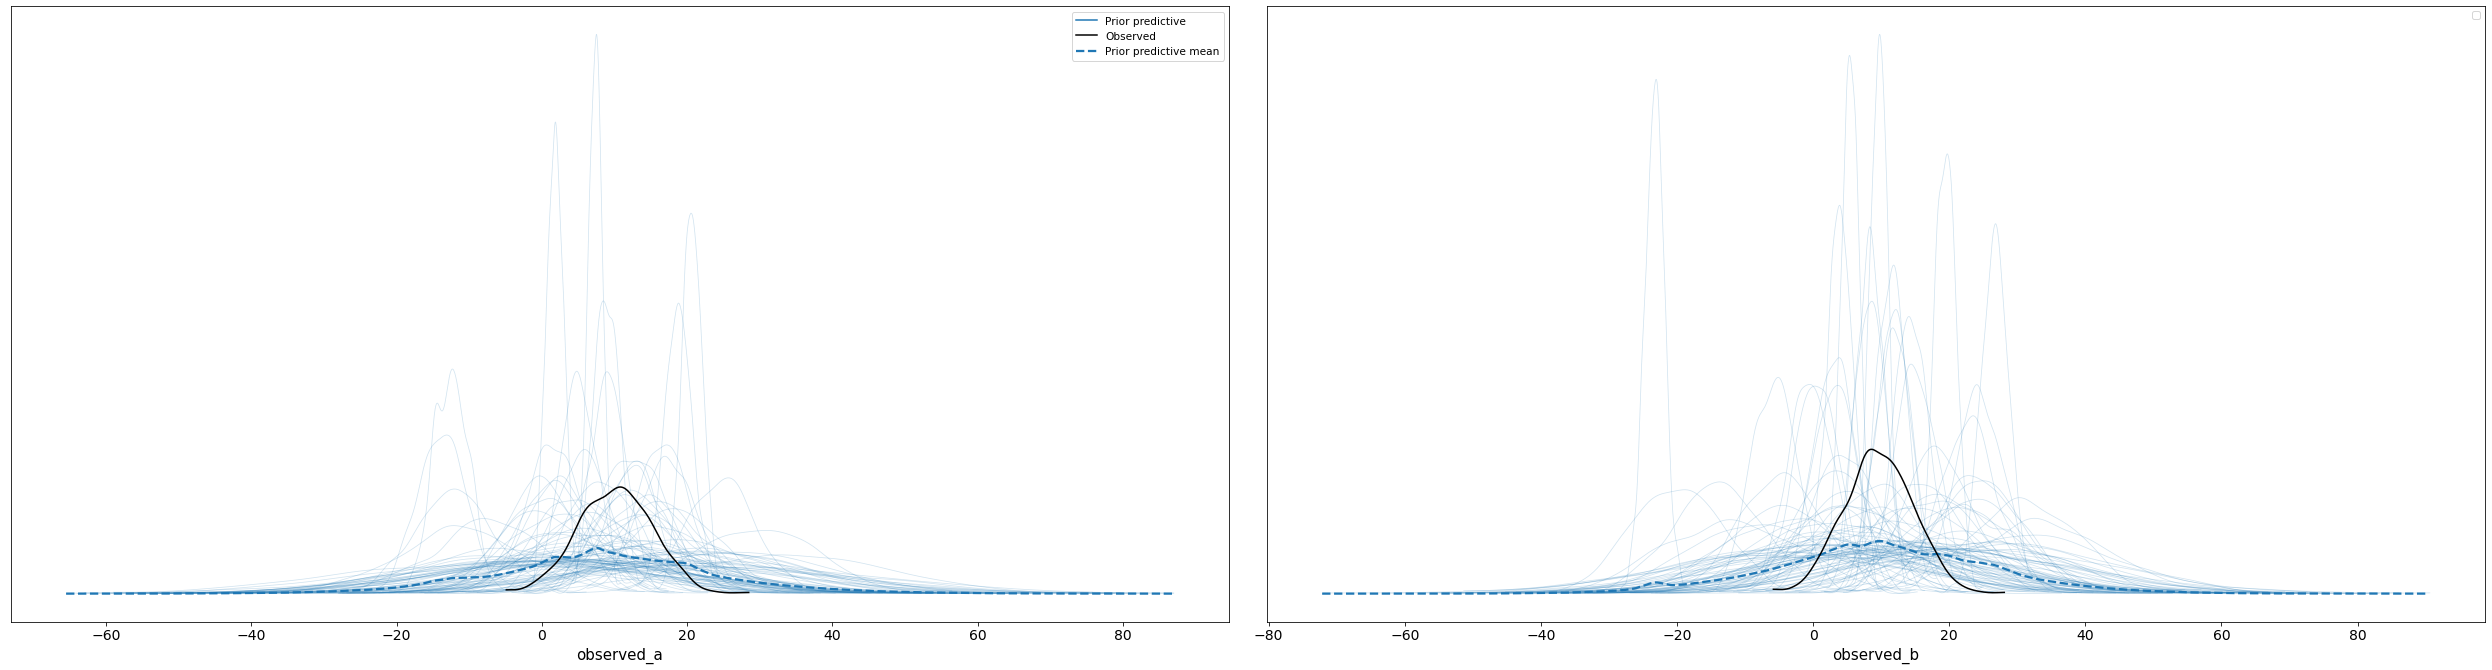

In [1029]:
az.plot_ppc(az.from_pymc3(prior=prior_predictive, model=model), num_pp_samples=100, group="prior");

### Posterior predictive check

In [1010]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["observed_a", "observed_b"])

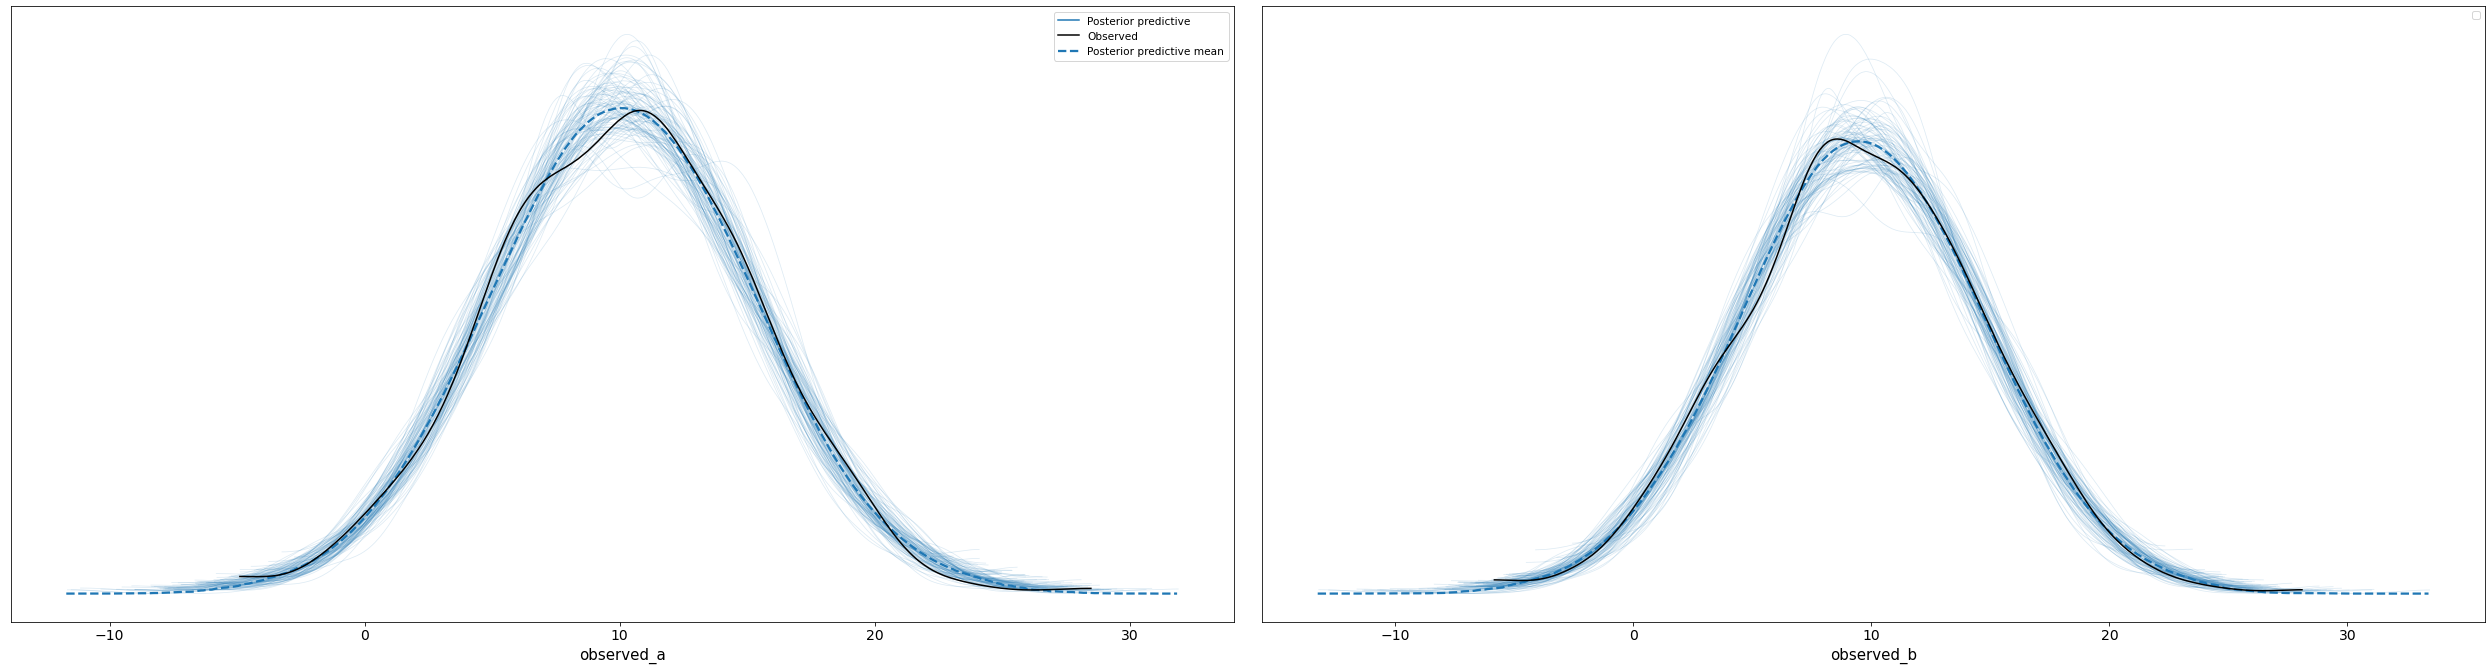

In [1011]:
_ = az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_predictive, model=model),
                num_pp_samples=100, alpha=.15)

### Results and decision

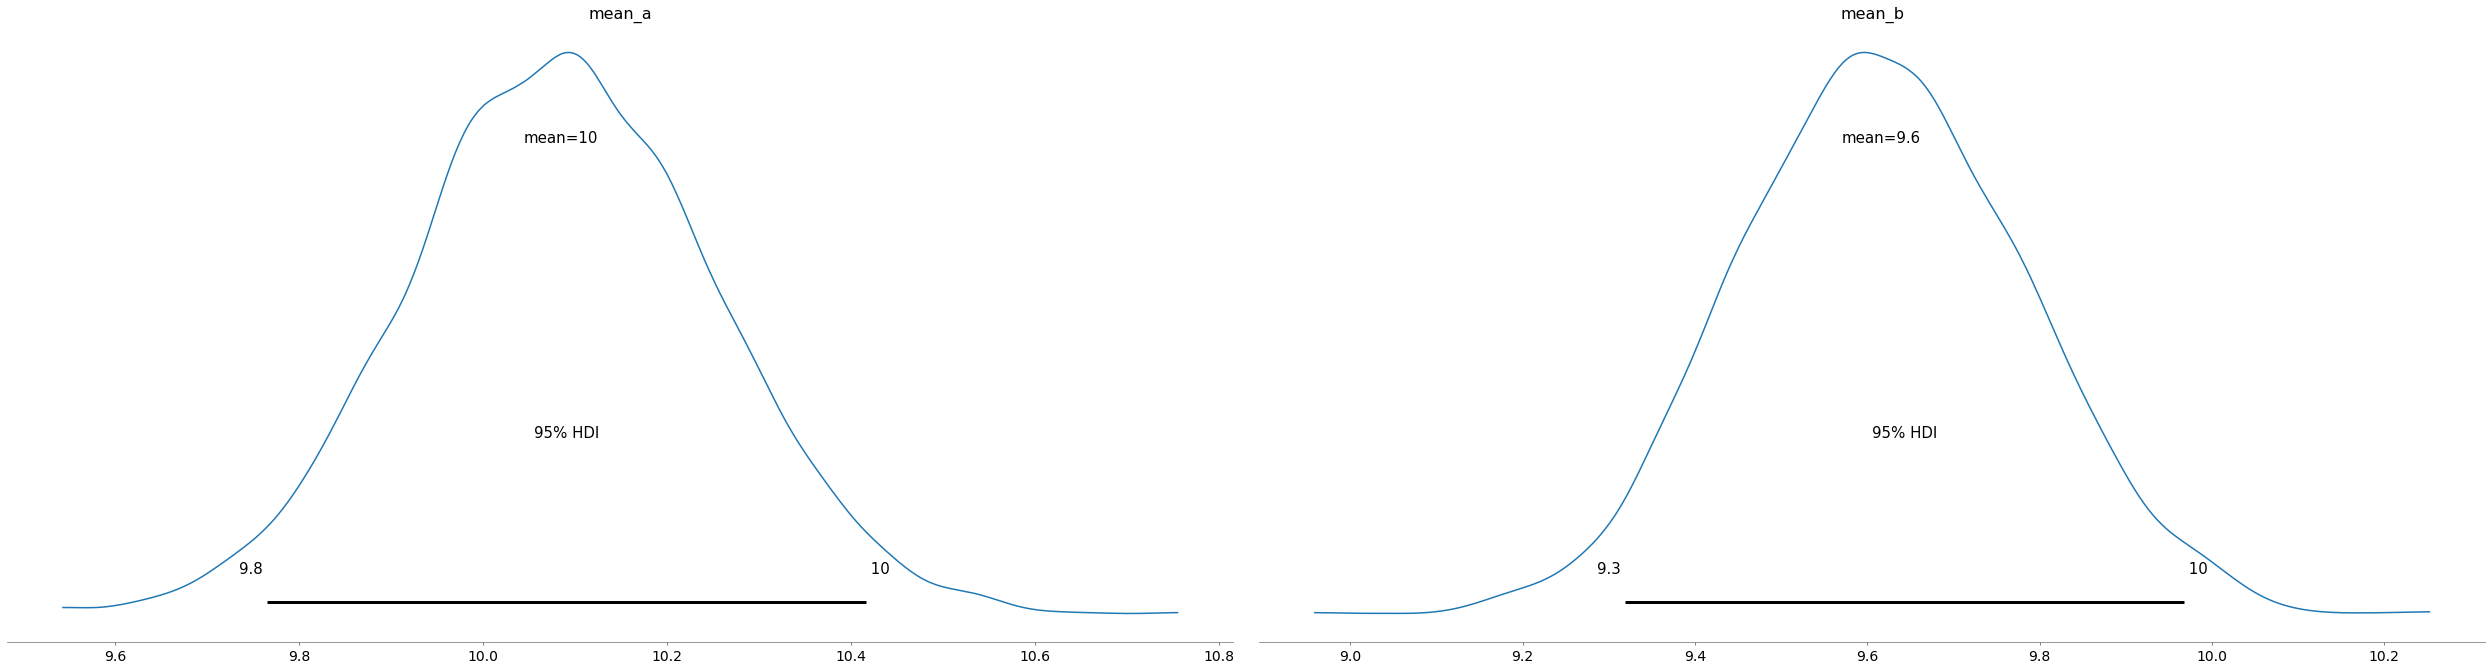

In [1012]:
with model:
    _ = pm.plot_posterior(trace, var_names=["mean_a", "mean_b"], hdi_prob=.95)

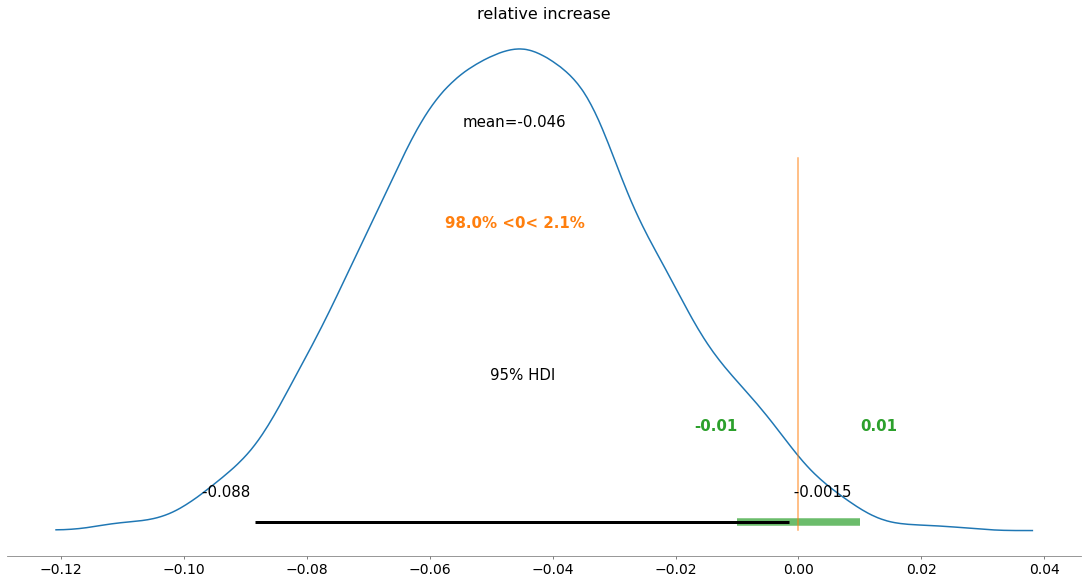

In [1014]:
with model:
    az.plot_posterior(trace, var_names=["relative increase"], hdi_prob=.95, ref_val=0, rope=(-.01, .01))

In [1034]:
prior_proba_h0 = ((prior_predictive['relative increase'] >= -.01) & (prior_predictive['relative increase'] <= .01)).mean()
prior_proba_h0

0.004

In [1035]:
proba_h0 = ((trace['relative increase'] >= -.01) & (trace['relative increase'] <= .01)).mean()
proba_h0

0.0565

In [1039]:
bayes_factor = (1 - proba_h0) / proba_h0 * prior_proba_h0 / (1 - prior_proba_h0)
bayes_factor

0.06706471905320396